## Overview

For our project we decided to build a classifier to tell whenever a song (based on its audio features) is gonna be in the top charts. For that purpose, have a main dataset of Spotify tracks from 1921 to 2020 from which we will use a subset of the last 10 years for this project; additionally, we have datasets for top tracks of the last 10 years, which we can use for aiding in the training and prediction of our model. The datasets we are gonna be using are:

- Tracks - https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks
- Top 2010 to 2019 - https://www.kaggle.com/leonardopena/top-spotify-songs-from-20102019-by-year
- Top 2017 - https://www.kaggle.com/nadintamer/top-tracks-of-2017
- Top 2018 - https://www.kaggle.com/nadintamer/top-spotify-tracks-of-2018
- Top 2019 - https://www.kaggle.com/leonardopena/top50spotify2019

The main idea is as follows:

1. Use the top charts datasets to create a lookup table of top songs.

2. Use the lookup table of top songs to create a new feature in our all tracks dataset to indicate if a given song was in the top charts before.

3. Use the tracks dataset (which is gonna have the new feature `topcharts`) to train and test our model.

The following steps on each phase are gonna be as follows:

### Preprocessing: part 1

1. Normalize the column names of our top tracks datasets.

2. Mark the year for each one.

3. Combine them to create our lookup table.

4. Use the lookup table to create the new `topcharts` feature in our main dataset.

### Exploration

1. Explore the the new main dataset.

2. Supervised scatter plot by `topcharts`.

3. Supervised scatter plot by `popularity`.

4. Correlation matrix.

5. Decide what features to keep and how to proceed.

### Preprocessing: part 2

1. Drop unnecessary features.

2. Prepare samples.

### Model creation

TBD

## Reading datasets

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
def read_dataset(name):
    url = os.path.join(os.getcwd(), '..', 'resources', name)
    return pd.read_csv(url)


In [3]:
datasets = [
    read_dataset('tracks-1921-2020.csv'),
    read_dataset('top-tracks-2010-to-2019.csv'),
    read_dataset('top-tracks-2017.csv'),
    read_dataset('top-tracks-2018.csv'),
    read_dataset('top-tracks-2019.csv'),
]

# indices constants for easier access later one
TRACKS_1921_2020 = 0
TOP_2010_2019_IDX = 1
TOP_2017_IDX = 2
TOP_2018_IDX = 3
TOP_2019_IDX = 4

## Preprocessing: part 1

### Normalizing columns

Some of the datasets have different column names to represent the same kind of metadata (name vs. title) or audio features (loudness vs. decibels). To address that, we are gonna normalize the columns so all the datasets have the same column names.

#### Column normalizer class

Let's get started by writing a column normalizer class that we can use later. The class focuses on mapping column names to a "desired" column set given as parameter, the class decides what column name corresponds to what input based on similarity tests.

In [4]:
from collections import namedtuple
from fuzzywuzzy import fuzz


Change = namedtuple('Change', ['before', 'after'])


class ColumnNormalizer:
    
    def __init__(self):
        pass
        
    def _compute_best_match(self, columns, oldname):
    
        best_match = None
        best_match_ratio = 0
        
        for colname in columns:
            ratio = fuzz.ratio(colname.lower(), oldname.lower())
            if ratio >= 60 and ratio > best_match_ratio:
                best_match = colname
                best_match_ratio = ratio
                
        return best_match
    
    def normalize(self, desired, desired_map, df):
        """
        Normalizes the column names of the given dataframe by looking at the `desired`
        set and the `desired_map` for supervised normalization. The `desired_map` 
        should contain a mapping from old names to desired names.
        """
        
        desired = desired or set()
        desired_map = desired_map or dict()
        
        guide = {name: name for name in desired}
        guide.update(desired_map)
        guide_keys = guide.keys()
        
        column_names = list(df.columns)
        changed = list()
        not_changed = list()
        
        for idx, colname in enumerate(column_names):
            
            best_key = self._compute_best_match(guide_keys, colname)

            if best_key is not None:
                column_names[idx] = guide[best_key]
                changed.append(Change(colname, guide[best_key]))
                
            else:
                not_changed.append(Change(colname, None))
                
        df.columns = column_names
        return df, changed, not_changed


#### Finding desired columns

Since most if not all of the datasets come from Spotify, we can look at their [API reference](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features/) to figure out which columns to expect. Easily enough, these are the most important columns we should try to get:

In [5]:
desired_columns = [
    
    # metadata
    'id',
    'artist',
    'title',
    'duration_ms',
    'genre',
    'popularity',
    'year',

    # audio features
    'acousticness',
    'danceability',
    'energy',
    'explicit',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence',
    
]

Since some of the datasets have badly naming columns, we have to provide a a desired map to the `ColumnNormalizer` for supervised column renaming. Said map is given by:

In [6]:
desired_columns_map = {
    
    'unamed': 'id',
    'bpm': 'tempo',
    'dnce': 'danceability',
    'db': 'loudness',
    'acous': 'acousticness',
    'spch': 'speechness',
    'pop': 'popularity',
    'Track.name': 'title',
    'beats.per.minute': 'tempo',
    'length': 'duration_ms',
    'dur': 'duration_ms',
    'name': 'title',
    'release_date': 'release_date',
    
}

#### Applying column normalization

Finally, we apply the `ColumnNormalizer` on each dataset to normalize the column names:

In [7]:
cnorm =  ColumnNormalizer()

changeset = set()
unchangeset = set()

for idx, dataset in enumerate(datasets):
    normalized, changed, not_changed = cnorm.normalize(desired_columns, desired_columns_map, dataset)
    changeset.update(changed)
    unchangeset.update(not_changed)
    datasets[idx] = normalized

To make sure no columns where left unchanged, we can simply check the `unchangeset` and make sure is empty:

In [8]:
assert len(unchangeset) == 0

### Marking by year

Since our `TOP_2010_2019_IDX` dataset is already marked by year, we only have to mark the remaining top charts datasets:

In [9]:
datasets[TOP_2017_IDX] = datasets[TOP_2017_IDX].assign(year=2017)
datasets[TOP_2018_IDX] = datasets[TOP_2018_IDX].assign(year=2018)
datasets[TOP_2019_IDX] = datasets[TOP_2019_IDX].assign(year=2019)

### Keeping common columns

Now that all the column names are normalized we can simply drop the columns that are not common in all our **secondary** datasets.

In [10]:
# grab only the secondary datasets with their index
secondary = list(enumerate(datasets))[1:]

all_columns = set()
for _, dataset in secondary:
    all_columns.update(dataset.columns)

common = set(all_columns)
for _, dataset in secondary:
    common.intersection_update(dataset.columns)

Then, we just have to update each **secondary** dataset and keep only the common column between them:

In [11]:
common_columns = sorted(list(common))

for idx, dataset in secondary:
    datasets[idx] = dataset[common_columns]

### Merging top charts

Now that all our top charts columns are normalized, they can be merged together. Note that we are only interested in `artist`, `title` and `year` (for determining if a song was in the top charts):

In [12]:
topcharts = pd.concat(datasets[1:])[['artist', 'title', 'year']]
topcharts

artist                                          title  year
0              Train                               Hey, Soul Sister  2010
1             Eminem                           Love The Way You Lie  2010
2              Kesha                                        TiK ToK  2010
3          Lady Gaga                                    Bad Romance  2010
4         Bruno Mars                           Just the Way You Are  2010
..               ...                                            ...   ...
45        Marshmello                                One Thing Right  2019
46         Nicky Jam                                      Te Robaré  2019
47        Marshmello                                        Happier  2019
48  The Chainsmokers                                  Call You Mine  2019
49        Ed Sheeran  Cross Me (feat. Chance the Rapper & PnB Rock)  2019

[853 rows x 3 columns]

### Top charts feature on main dataset

Based on the merged top charts, we are now going to add new binary feature to our main dataset that indicates if a song was in the top charts. In order to do so, we use our `topcharts` dataset as a lookup table, any row in the main dataset that is found in the top charts will marked with a `Y`, any other row will be marked with `N`. First, let us prepare the `topcharts` so we can use it as a lookup table more efficiently:

In [13]:
import re

# removes any non-letter character from the given string
def normalize_string(s):
    return re.sub(r'\W+', '', s.lower())

# compares the given strings and returns similarity ratio
def string_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()


In [14]:
topcharts['artist'] = topcharts['artist'].map(normalize_string)
topcharts['title'] = topcharts['title'].map(normalize_string)
topcharts = topcharts.drop_duplicates()
topcharts

artist             title  year
0        train     heysoulsister  2010
1       eminem  lovethewayyoulie  2010
2        kesha            tiktok  2010
3     ladygaga        badromance  2010
4    brunomars  justthewayyouare  2010
..         ...               ...   ...
42    ladygaga           shallow  2019
43      khalid              talk  2019
44     rosalía         conaltura  2019
45  marshmello     onethingright  2019
46    nickyjam          terobaré  2019

[806 rows x 3 columns]

#### Generating topcharts dataset

In [15]:
REGENERATE_TOPCHARTS = False

In [16]:
tracks_path = os.path.join(os.getcwd(), '..', 'resources', 'tracks-2010-2019-topcharts.csv')

In [17]:
import re
from fuzzywuzzy import fuzz


if REGENERATE_TOPCHARTS:
    
    
    def find_track(artist, title, lookup, artist_threshold=0.5, title_threshold=0.75):
        """
        Determines if the given track (artist, title) is in the given lookup table.
        Uses similarity comparison on both fields, so it may be slow for large datasets.
        """
        r = lookup.copy()
        r['artist'] = r['artist'].map(lambda x: fuzz.ratio(artist, x))
        r['title'] = r['title'].map(lambda x: fuzz.ratio(title, x))
        return not r[(r['artist'] >= artist_threshold * 100) & (r['title'] >= title_threshold * 100)].empty


    # grab last 10 years from our main dataset
    tracks = datasets[0][datasets[0]['year'] >= 2010]
    tracks = tracks.assign(topcharts='N')
    tracks = tracks.reset_index(drop=True)


    total_rows = len(tracks.index)


    for idx, row in enumerate(tracks.itertuples()):

        artist = normalize_string(row.artist)
        title = normalize_string(row.title)

        if find_track(artist, title, top_charts):
            tracks.at[idx, 'topcharts'] = 'Y'

        if idx % 1000 == 0:
            print(f"Completed {idx / total_rows * 100}%")
        
    output = os.path.join(os.getcwd(), '..', 'resources', 'tracks-2010-2019-topcharts.csv')
    tracks.to_csv(tracks_path)

In [18]:
if not REGENERATE_TOPCHARTS:
    
    tracks = pd.read_csv(tracks_path, index_col=0)

## Exploration

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21656 entries, 0 to 21655
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      21656 non-null  float64
 1   artist            21656 non-null  object 
 2   danceability      21656 non-null  float64
 3   duration_ms       21656 non-null  int64  
 4   energy            21656 non-null  float64
 5   explicit          21656 non-null  int64  
 6   id                21656 non-null  object 
 7   instrumentalness  21656 non-null  float64
 8   key               21656 non-null  int64  
 9   liveness          21656 non-null  float64
 10  loudness          21656 non-null  float64
 11  mode              21656 non-null  int64  
 12  title             21656 non-null  object 
 13  popularity        21656 non-null  int64  
 14  release_date      21656 non-null  object 
 15  speechiness       21656 non-null  float64
 16  tempo             21656 non-null  float6

In [21]:
tracks.describe()

acousticness  danceability   duration_ms        energy      explicit  \
count  21656.000000  21656.000000  2.165600e+04  21656.000000  21656.000000   
mean       0.255491      0.605048  2.224077e+05      0.631091      0.302734   
std        0.287580      0.170475  8.546179e+04      0.217466      0.459452   
min        0.000000      0.000000  3.030100e+04      0.000020      0.000000   
25%        0.026075      0.502000  1.871930e+05      0.500000      0.000000   
50%        0.131000      0.618000  2.148800e+05      0.658000      0.000000   
75%        0.409000      0.730000  2.463218e+05      0.798000      1.000000   
max        0.996000      0.986000  5.403500e+06      1.000000      1.000000   

       instrumentalness           key      liveness      loudness  \
count      21656.000000  21656.000000  21656.000000  21656.000000   
mean           0.068246      5.201884      0.188202     -7.368521   
std            0.217755      3.596384      0.152302      4.695158   
min            0.000000      0.000000      0.000000    -54.376000   
25%            0.000000      2.000000      0.097500     -8.332000   
50%            0.000001      5.000000      0.124000     -6.282500   
75%            0.000450      8.000000      0.232000     -4.806000   
max            1.000000     11.000000      0.990000      1.023000   

              mode    popularity   speechiness         tempo       valence  \
count  21656.00000  21656.000000  21656.000000  21656.000000  21656.000000   
mean       0.64698     59.850526      0.104421    120.820850      0.463231   
std        0.47792     10.537460      0.110202     30.662387      0.240015   
min        0.00000      0.000000      0.000000      0.000000      0.000000   
25%        0.00000     53.000000      0.037200     96.808250      0.276000   
50%        1.00000     60.000000      0.054900    120.051000      0.452000   
75%        1.00000     66.000000      0.123000    140.923250      0.643000   
max        1.00000    100.000000      0.950000    220.099000      0.990000   

               year  
count  21656.000000  
mean    2014.942233  
std        3.142110  
min     2010.000000  
25%     2012.000000  
50%     2015.000000  
75%     2018.000000  
max     2020.000000

### Supervised scatter plot

#### Colored by topcharts

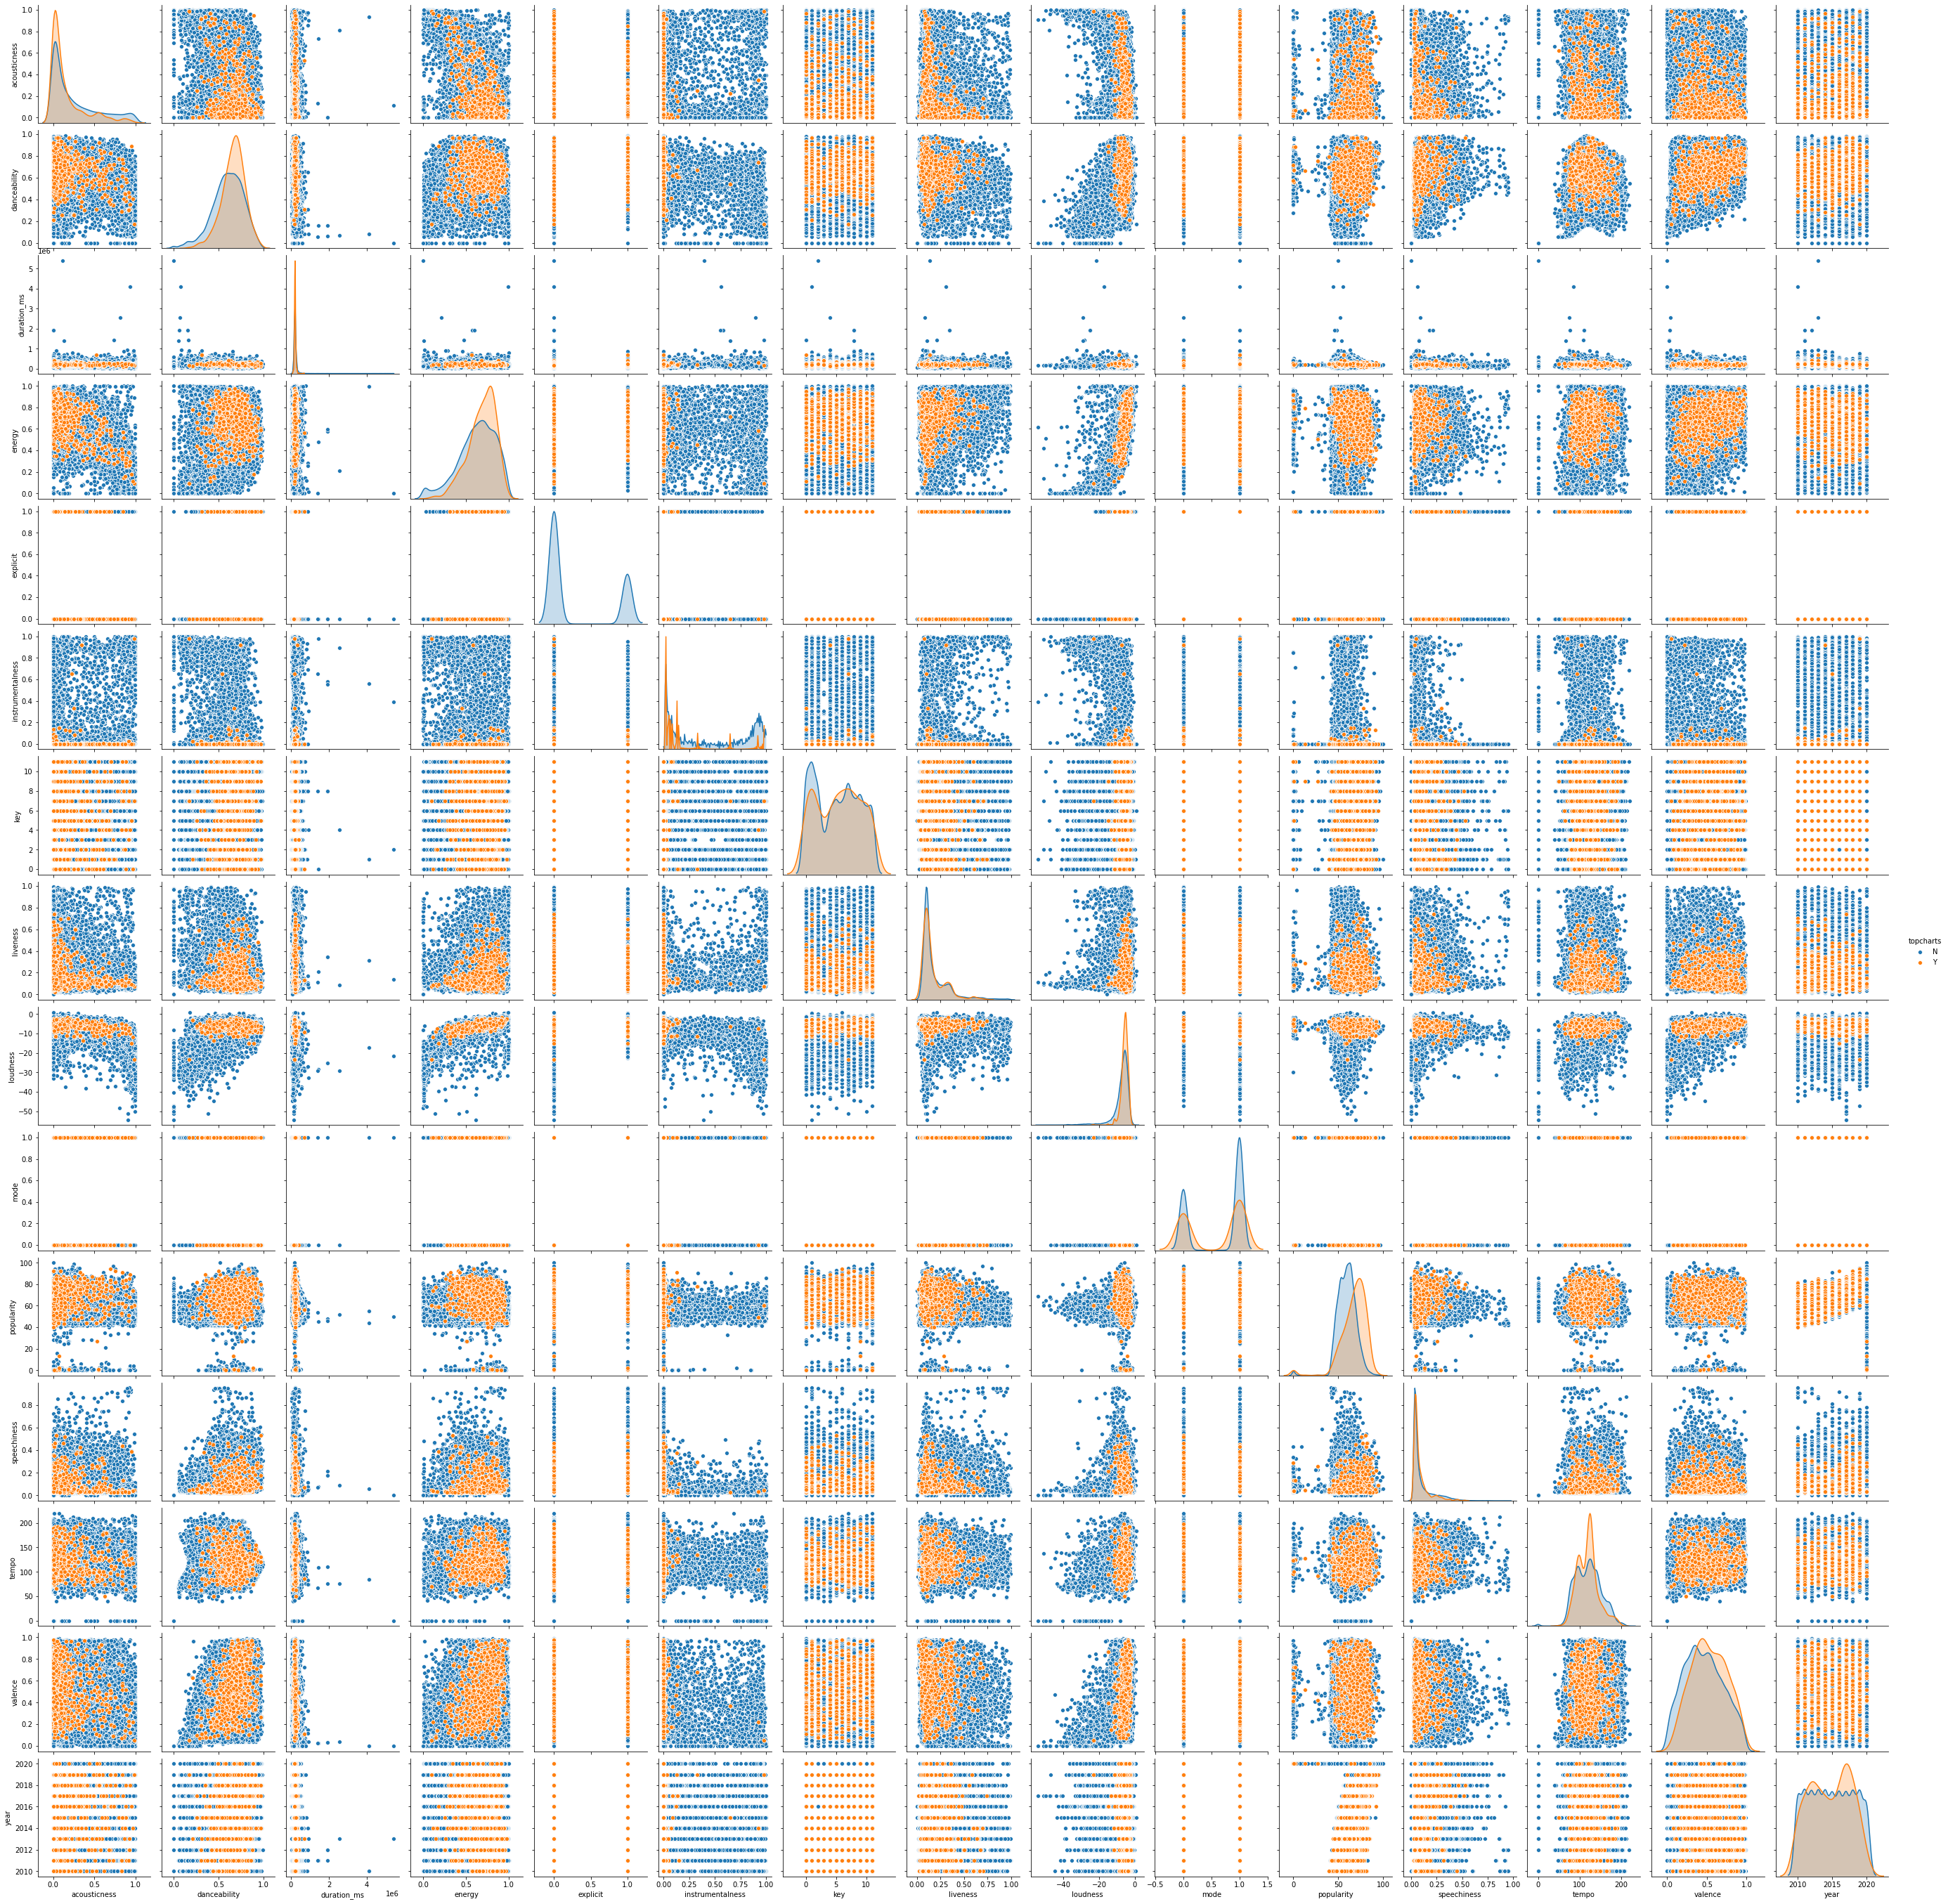

In [22]:
from IPython.display import Image
# sns.pairplot(tracks, hue='topcharts') # NOTE: cached using image below
Image('tracks-topcharts-colored.png')

**Observations** from looking at the diagonal histograms.

Different:

1. Songs that made it to the top charts are much more danceable.

2. Songs in the top charts have more energy (more loud, fast, noisy, etc).

3. No songs in the top charts is explicit.

4. Songs in the top charts have low instrumentalness (i.e. more vocal content).

5. Songs in top charts have slightly lower liveness (no audience in the recordings).

6. Songs in top charts are louder (decibels).

7. Songs in top charts are more popular.

8. Songs in top charts have more tempo (beats per minute).

9. Top charts have slightly higher valence (happier positive mood).

Kind of the same:

1. Duration.

2. Key.

3. Speechness.

Irrelevant for modelling:

1. Year.

2. Other string fields.

Other (requires more work, checking, etc):

1. Duration has outliers, we have to remove them.

2. Instrumentalness might be correlated with speechness.

3. Energy might be correlated to loudness and tempo.

#### Coloredby popularity

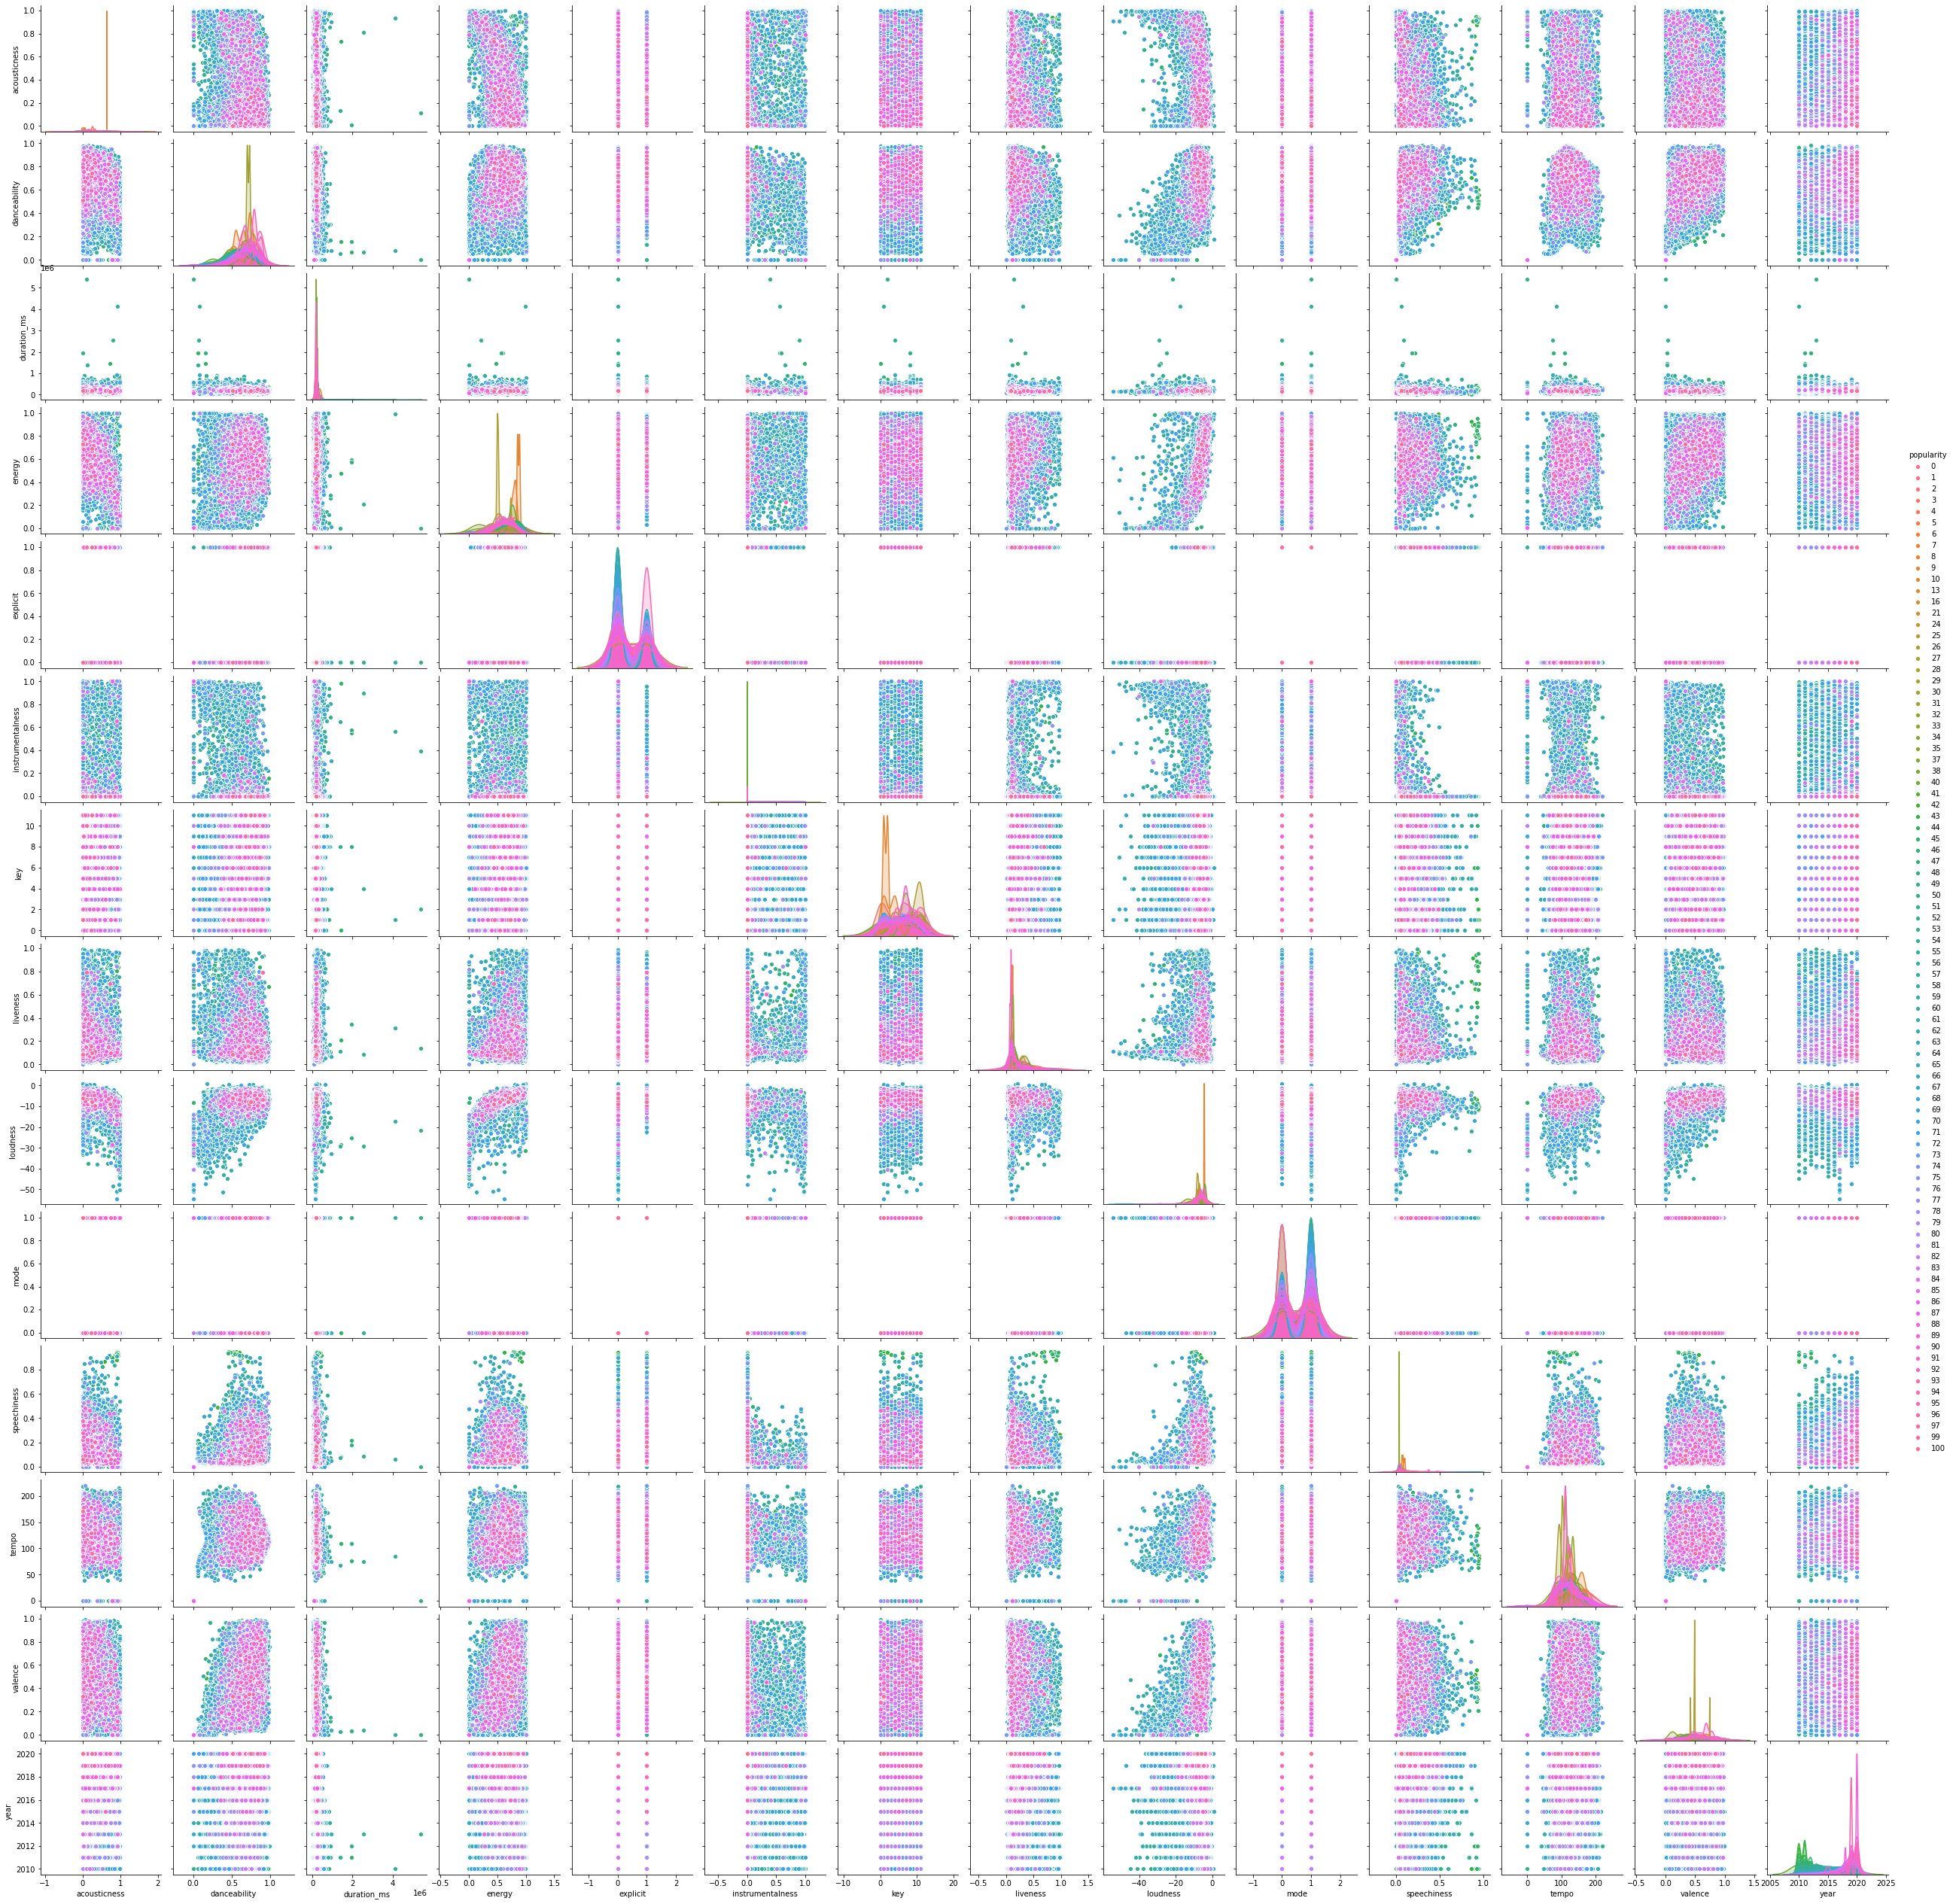

In [23]:
from IPython.display import Image
# sns.pairplot(tracks, hue='popularity') # NOTE: cached using image below
Image('tracks-popularity-colored.png')

### Correlation matrix

In [24]:
corr = tracks.corr()

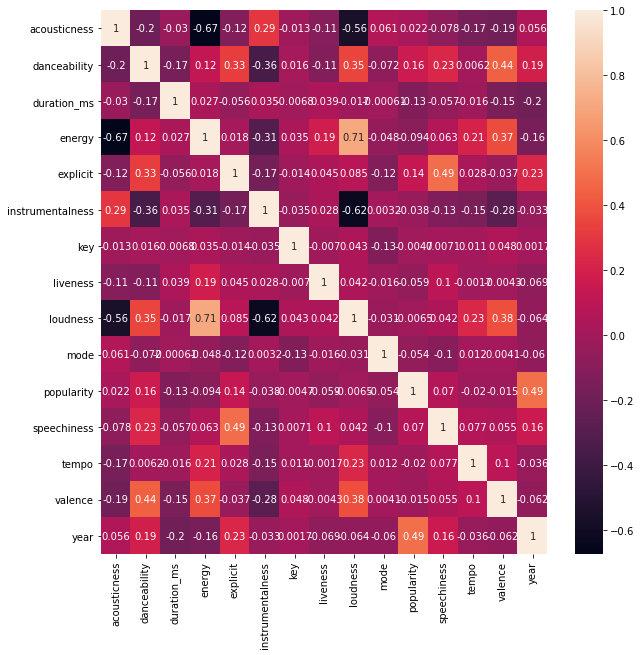

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, ax=ax)

Based on the data and the correlation matrix, we are gonna remove the following features:

In [26]:
features_to_remove = ['artist', 'title', 'duration_ms', 'id', 'key', 'liveness', 'mode', 'release_date']

### Partitioning tracks

Let's see how many tracks of each class label we have:

In [27]:
tracks_topcharts = tracks[tracks['topcharts'] == 'Y']
tracks_notopcharts = tracks[tracks['topcharts'] == 'N']

In [28]:
print(f"Total tracks that are in the top charts: {len(tracks_topcharts)}")
print(f"Total tracks that are not in the top charts: {len(tracks_notopcharts)}")

Total tracks that are in the top charts: 772
Total tracks that are not in the top charts: 20884


We need to find a way to balance the numbers above, otherwise, the model will be biased towards tracks **not in the top charts**.

#### Dealing with imbalanced classes

Right now we have unbalanced classes, where the **minority** class are the tracks that were in the top charts, and the **majority** class are the tracks that were not in the top charts. For our case, over-sampling the **minority** class will help with balancing the classes in our dataset, which will help for creating a more effective model.

----

## Preprocessing: part 2

In [29]:
tracks_model = tracks.drop(features_to_remove, axis=1)

xs = tracks_model.drop('topcharts', axis=1)
y = tracks_model['topcharts']

### Over-sampling minority class

We are gonna make use of the library [imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) to help with the over-sampling of our data.

In [30]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

ros = SMOTE(random_state=123)

In [31]:
xs_resampled, y_resampled = ros.fit_resample(xs, y)
xs_resampled

acousticness  danceability    energy  explicit  instrumentalness  \
0          0.022200      0.450000  0.849000         0      4.550000e-03   
1          0.000103      0.382000  0.943000         0      1.100000e-04   
2          0.852000      0.179000  0.167000         0      7.480000e-01   
3          0.080900      0.507000  0.770000         0      0.000000e+00   
4          0.002960      0.315000  0.925000         0      6.420000e-02   
...             ...           ...       ...       ...               ...   
41763      0.086006      0.624753  0.643839         0      2.109894e-05   
41764      0.447368      0.625532  0.615390         0      1.132028e-05   
41765      0.631477      0.566510  0.664230         0      0.000000e+00   
41766      0.106846      0.747689  0.854443         0      4.909394e-05   
41767      0.043043      0.748043  0.709581         0      9.701037e-08   

        loudness  popularity  speechiness       tempo   valence  year  
0      -5.075000          48     0.057000  139.925000  0.161000  2010  
1      -5.434000          50     0.087200  105.032000  0.128000  2010  
2     -23.408000          48     0.039400  124.266000  0.039900  2010  
3      -5.018000          48     0.042400  155.945000  0.482000  2010  
4      -4.507000          47     0.117000  185.305000  0.415000  2010  
...          ...         ...          ...         ...       ...   ...  
41763  -6.857461          75     0.037975  103.410099  0.476925  2017  
41764  -6.783311          71     0.100946   99.520484  0.410114  2017  
41765  -5.307879          72     0.046374  128.938179  0.437605  2013  
41766  -3.145819          74     0.073142   92.410354  0.770291  2016  
41767  -5.436838          49     0.031644  120.028501  0.883771  2013  

[41768 rows x 11 columns]

## Model creation

### Training

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(xs_resampled)

xs_train, xs_test, y_train, y_test = train_test_split(
    scaler.transform(xs_resampled),
    y_resampled,
    train_size=0.7,
    test_size=0.3,
    stratify=y_resampled,
    random_state=123)

In [33]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(xs_train, y_train)

LogisticRegression()

In [34]:
model.score(xs_test, y_test)

0.7855717819806879

### Using random forest

### Comparing with random forest performance
#### from _067_random_forest.ppt week 7 slide 55-58

In [35]:
y_resampled_encoded = pd.Series(np.where(y_resampled.values == 'Y', 2, 1), y_resampled.index)
y_resampled_encoded

0        1
1        1
2        1
3        1
4        1
        ..
41763    2
41764    2
41765    2
41766    2
41767    2
Length: 41768, dtype: int64

In [36]:
labels = np.array(y_resampled_encoded)
feature_list = list(xs_resampled.columns)
features = np.array(xs_resampled)

In [37]:
train_features, test_features, train_labels, test_labels = train_test_split(
    #scaler.transform(xs_resampled),
    features,
    labels,
    test_size=0.25,
    stratify=labels,
    random_state=123)

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Features Shape:', test_labels.shape)

Training Features Shape: (31326, 11)
Training Labels Shape: (31326,)
Testing Features Shape: (10442, 11)
Testing Features Shape: (10442,)


In [38]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1, random_state=42)

In [39]:
predictions = rf.predict(test_features)
errors = abs(predictions - test_labels)

print('Mean Absolute Error:', round(np.mean(errors), 2), 'degress.')

Mean Absolute Error: 0.08 degress.


In [40]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%')

Accuracy: 93.0 %


In [42]:
from sklearn.tree import export_graphviz
# sudo apt install graphviz
# pip install graphviz does not solve the issue
# pip install pydot
import pydot

#pulling out a tree from the forest

tree = rf.estimators_[0]

export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

#use the exported dot file to graph, and then to .png file
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')